<a href="https://colab.research.google.com/github/Kymapo/AMATH581/blob/main/AMATH581HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
from scipy.sparse import spdiags, kron, eye
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp

import time

from scipy.linalg import lu, solve_triangular
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import gmres

from IPython.display import Image

In [31]:
# Parameters
L = 20  # Length of the domain in x and y directions (from -10 to 10)
n = 128   # Number of grid points in each direction
dx = L / n  # Grid spacing

# Finite difference stencils
laplacian_data = np.array([np.ones(n), -2 * np.ones(n), np.ones(n)])  # For second derivative
first_derivative_data = np.array([-0.5 * np.ones(n), np.zeros(n), 0.5 * np.ones(n)])  # For first derivative

# Generate 1D second derivative (Laplacian) matrix with periodic boundary conditions
D2 = spdiags(laplacian_data, [-1, 0, 1], n, n) / dx**2
D2 = D2.tolil()
D2[0, -1] = 1 / dx**2  # periodic condition on the left edge
D2[-1, 0] = 1 / dx**2  # periodic condition on the right edge

# Generate 1D first derivative matrices (with periodic BCs)
D1x = spdiags(first_derivative_data, [-1, 0, 1], n, n) / dx
D1x = D1x.tolil()
D1x[0, -1] = -0.5 / dx  # periodic condition for left edge
D1x[-1, 0] = 0.5 / dx   # periodic condition for right edge

D1y = D1x.copy()  # same for y since it's a square grid

# Convert matrices to CSR format for further operations
D2 = D2.tocsr()
D1x = D1x.tocsr()
D1y = D1y.tocsr()

# 2D Laplacian using Kronecker product for ∂²x + ∂²y
A = kron(D2, eye(n)) + kron(eye(n), D2)

# 2D first derivatives in x and y directions using Kronecker product
B = kron(D1x, eye(n))
C = kron(eye(n), D1y)

# Convert sparse matrices to full matrices as required
A = A.toarray()
B = B.toarray()
C = C.toarray()

Elapsed time:11.0094153881073 seconds
[[2.50656748e-46 5.17806250e-46 9.08370364e-46 ... 5.23293081e-45
  7.72097202e-45 1.12911691e-44]
 [5.56732742e-45 8.27410286e-45 1.22084335e-44 ... 5.45821204e-44
  7.84817465e-44 1.12427128e-43]
 [1.17762859e-43 1.71580910e-43 2.48500123e-43 ... 1.04397375e-42
  1.48182369e-42 2.09803714e-42]
 ...
 [2.77008122e-42 4.14041078e-42 6.15267603e-42 ... 2.85924705e-41
  4.16312467e-41 6.04175592e-41]
 [1.37510769e-43 2.10314979e-43 3.19273255e-43 ... 1.59425243e-42
  2.35460469e-42 3.46751668e-42]
 [6.50092464e-45 1.01835404e-44 1.58180256e-44 ... 8.51326629e-44
  1.27792565e-43 1.90786332e-43]]


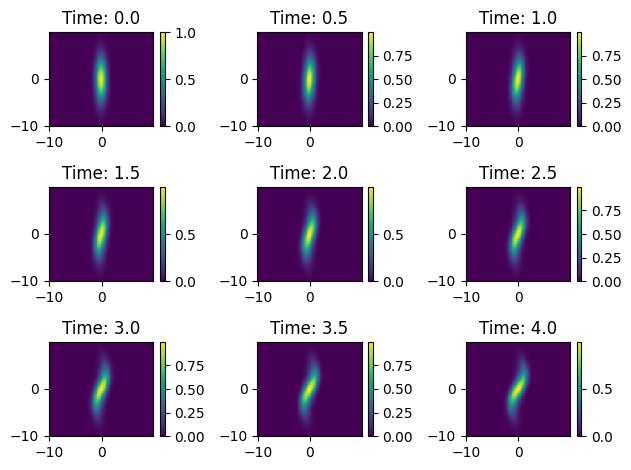

In [32]:
# Define parameters
tspan = np.linspace(0, 4, 9)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 128, 128
N = nx * ny

start_time = time.time()

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(-X**2 - Y**2 / 20)  # Initialize as complex
wt0 = w.reshape(N)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system
def spc_rhs(t, w, nx, ny, N, K, nu):
    #wtc = wt2[0:N] + 1j*wt2[N:]
    wt = fft2(w.reshape(nx, ny))
    #w = wt2.reshape((nx, ny))
    psit = ifft2(-wt / K)
    psi = np.real(psit)
    #psix = np.real(ifft2(1j * KX * psit))
    #psiy = np.real(ifft2(1j * KY * psit))
    #wx = np.real(ifft2(1j * KX * wt))
    #wy = np.real(ifft2(1j * KY * wt))
    rhs = nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)
    return rhs
# Solve the ODE and plot the results
wt0 = w.flatten()
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)

end_time = time.time()
elapsed_time = end_time - start_time

A1 = wtsol.y

print(f"Elapsed time:{elapsed_time} seconds")
print(A1)

for j, t in enumerate(tspan):
    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))
    # Reshape to (nx, ny) and apply ifft2
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [33]:
'''
start_time = time.time()

A[0, 0] = 2 / dx**2

def linalg_rhs(t, w):
    psi = np.linalg.solve(A, w)
    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)

wtsol2 = solve_ivp(linalg_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan)

end_time = time.time()
elapsed_time = end_time - start_time

A2 = wtsol2.y
print(f"Elapsed time:{elapsed_time} seconds")
print(A2)

for j, t in enumerate(tspan):
    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))
    # Reshape to (nx, ny) and apply ifft2
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()
'''

'\nstart_time = time.time()\n\nA[0, 0] = 2 / dx**2\n\ndef linalg_rhs(t, w):\n    psi = np.linalg.solve(A, w)\n    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)\n\nwtsol2 = solve_ivp(linalg_rhs, [tspan[0], tspan[-1]], wt0, method=\'RK45\', t_eval=tspan)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nA2 = wtsol2.y\nprint(f"Elapsed time:{elapsed_time} seconds")\nprint(A2)\n\nfor j, t in enumerate(tspan):\n    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))\n    # Reshape to (nx, ny) and apply ifft2\n    plt.subplot(3, 3, j + 1)\n    plt.pcolor(x, y, w, shading=\'auto\')\n    plt.title(f\'Time: {t}\')\n    plt.colorbar()\n\nplt.tight_layout()\nplt.show()\n'

In [34]:
'''
start_time = time.time()

def lu_rhs(t, w):
    P, L, U = lu(A)
    Pw = np.dot(P, w.flatten())
    y = solve_triangular(L, Pw, lower=True)
    psi = solve_triangular(U, y)
    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)

wtsol3 = solve_ivp(lu_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan)

end_time = time.time()
elapsed_time = end_time - start_time

A3 = wtsol3.y
print(f"Elapsed time:{elapsed_time} seconds")
print(A3)

for j, t in enumerate(tspan):
    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))
    # Reshape to (nx, ny) and apply ifft2
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()
'''

'\nstart_time = time.time()\n\ndef lu_rhs(t, w):\n    P, L, U = lu(A)\n    Pw = np.dot(P, w.flatten())\n    y = solve_triangular(L, Pw, lower=True)\n    psi = solve_triangular(U, y)\n    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)\n\nwtsol3 = solve_ivp(lu_rhs, [tspan[0], tspan[-1]], wt0, method=\'RK45\', t_eval=tspan)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nA3 = wtsol3.y\nprint(f"Elapsed time:{elapsed_time} seconds")\nprint(A3)\n\nfor j, t in enumerate(tspan):\n    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))\n    # Reshape to (nx, ny) and apply ifft2\n    plt.subplot(3, 3, j + 1)\n    plt.pcolor(x, y, w, shading=\'auto\')\n    plt.title(f\'Time: {t}\')\n    plt.colorbar()\n\nplt.tight_layout()\nplt.show()\n'

In [35]:
'''
def bicgstab_rhs(t, w):
    psi, info = bicgstab(A, w.flatten())
    if info != 0:
        print(f"bicgstab did not converge. info: {info}")
    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)

start_time = time.time()

wtsol_bicgstab = solve_ivp(bicgstab_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time (bicgstab): {elapsed_time} seconds")
print(wtsol_bicgstab.y)
'''

'\ndef bicgstab_rhs(t, w):\n    psi, info = bicgstab(A, w.flatten())\n    if info != 0:\n        print(f"bicgstab did not converge. info: {info}")\n    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)\n\nstart_time = time.time()\n\nwtsol_bicgstab = solve_ivp(bicgstab_rhs, [tspan[0], tspan[-1]], wt0, method=\'RK45\', t_eval=tspan)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nprint(f"Elapsed time (bicgstab): {elapsed_time} seconds")\nprint(wtsol_bicgstab.y)\n'

In [36]:
'''
def gmres_rhs(t, w):
    psi, info = gmres(A, w.flatten())
    if info != 0:
        print(f"gmres did not converge. info: {info}")
    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)

start_time = time.time()

wtsol_gmres = solve_ivp(gmres_rhs, [tspan[0], tspan[-1]], wt0, t_eval=tspan)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time (gmres): {elapsed_time} seconds")
print(wtsol_gmres.y)
'''

'\ndef gmres_rhs(t, w):\n    psi, info = gmres(A, w.flatten())\n    if info != 0:\n        print(f"gmres did not converge. info: {info}")\n    return nu * np.dot(A, w) - np.dot(B, psi.flatten()) * np.dot(C, w) + np.dot(C, psi.flatten()) * np.dot(B, w)\n\nstart_time = time.time()\n\nwtsol_gmres = solve_ivp(gmres_rhs, [tspan[0], tspan[-1]], wt0, t_eval=tspan)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nprint(f"Elapsed time (gmres): {elapsed_time} seconds")\nprint(wtsol_gmres.y)\n'

In [37]:

import matplotlib.animation as animation
from IPython.display import HTML


def animate(j):
    ax.clear()  # Clear the previous frame from the axes
    w = np.real(wtsol.y.T[j, :N].reshape((nx, ny)))
    im = ax.pcolor(x, y, w, shading='auto') # Store the pcolor object
    ax.set_title(f'Time: {tspan[j]}')
    # Only create colorbar once, update it with each frame
    im.set_array(w.ravel())  # Update pcolor data



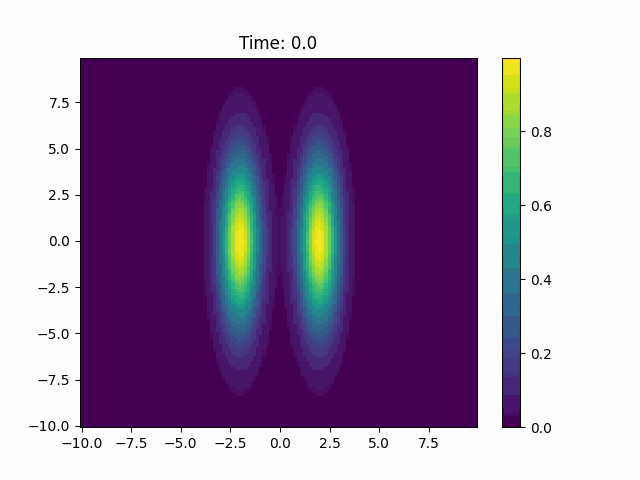

In [38]:
tspan = np.linspace(0, 20, 21)


w1 = 1 * np.exp(-(X - 2)**2 - (Y)**2 / 20)  # Positive vortex
w2 = 1 * np.exp(-(X + 2)**2 - (Y)**2 / 20)  # Negative vortex

# Combine the vortices
w = w1 + w2

# Reshape for FFT
wt0 = w.reshape(N)

wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)


fig, ax = plt.subplots()
im = ax.pcolor(x, y, w, shading='auto')
cbar = fig.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=len(tspan), interval=200, blit=False)
plt.close()
HTML(ani.to_jshtml())

ani.save('Two-same-charged.gif', writer='pillow')
display(Image(filename='Two-same-charged.gif'))

![Animation](Two-same-charged.gif)

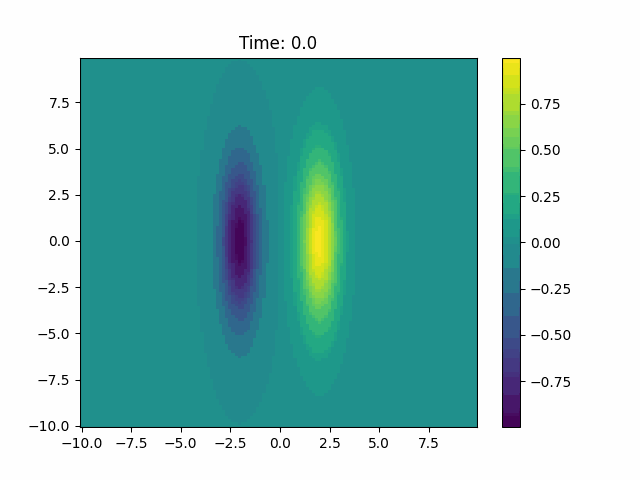

In [39]:
w = w1 - w2

# Reshape for FFT
wt0 = w.reshape(N)

wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)


fig, ax = plt.subplots()
im = ax.pcolor(x, y, w, shading='auto')
cbar = fig.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=len(tspan), interval=200, blit=False)
plt.close()
HTML(ani.to_jshtml())

ani.save('Two-different-charged.gif', writer='pillow')
display(Image(filename='Two-different-charged.gif'))

![Animation](Two-different-charged.gif)

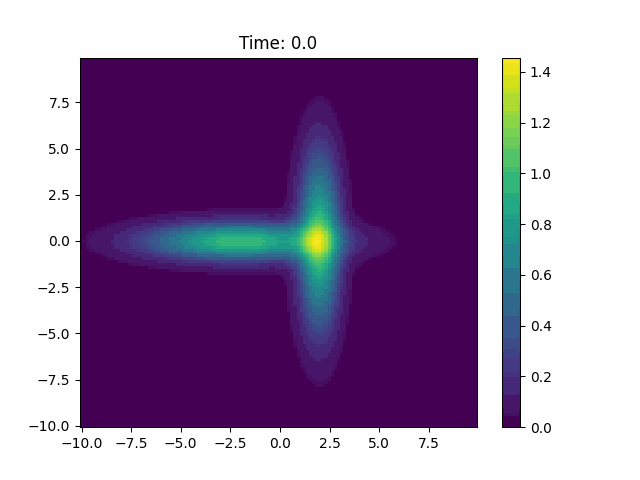

In [40]:
w1 = 1 * np.exp(-(X - 2)**2 - (Y)**2 / 20)  # Positive vortex
w2 = 1 * np.exp(-(X + 2)**2 / 20 - (Y)**2)  # Negative vortex

# Combine the vortices
w = w1 + w2

# Reshape for FFT
wt0 = w.reshape(N)

wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)

fig, ax = plt.subplots()
im = ax.pcolor(x, y, w, shading='auto')
cbar = fig.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=len(tspan), interval=200, blit=False)
plt.close()
HTML(ani.to_jshtml())

ani.save('Two-same-colliding.gif', writer='pillow')
display(Image(filename='Two-same-colliding.gif'))

![Animation](Two-same-colliding.gif)

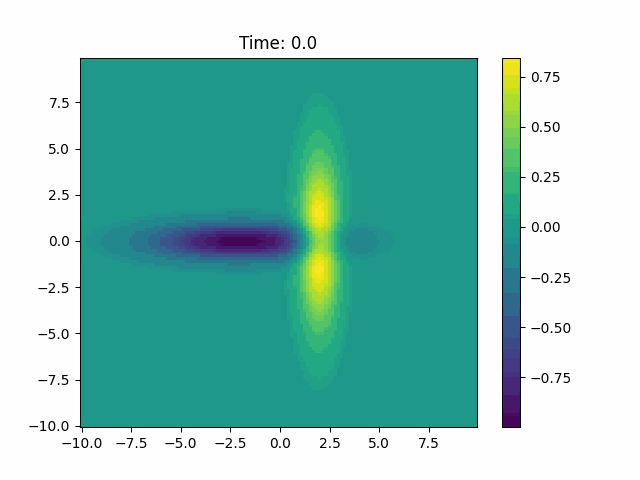

In [41]:
w = w1 - w2
wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)

fig, ax = plt.subplots()
im = ax.pcolor(x, y, w, shading='auto')
cbar = fig.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=len(tspan), interval=200, blit=False)
plt.close()
HTML(ani.to_jshtml())

ani.save('Two-different-colliding.gif', writer='pillow')
display(Image(filename='Two-different-colliding.gif'))

![Animation](Two-different-colliding.gif)

In [42]:
def generate_random_vortices(num_vortices, X, Y, Lx, Ly):
    """Generates a random assortment of vortices.

    Args:
        num_vortices: The number of vortices to generate.
        X, Y: Meshgrid representing the domain.
        Lx, Ly: Domain size in x and y directions.

    Returns:
        w: The combined vorticity field of all vortices.
    """

    w = np.zeros_like(X, dtype=float)  # Initialize vorticity field

    for _ in range(num_vortices):
        # Randomly choose vortex properties
        x_center = np.random.uniform(-Lx / 2, Lx / 2)
        y_center = np.random.uniform(-Ly / 2, Ly / 2)
        strength = np.random.uniform(0.5, 1.5)  # Adjust range as needed
        charge = np.random.choice([-1, 1])  # Positive or negative vortex
        x_ellipticity = np.random.uniform(1, 7)  # Adjust range as needed
        y_ellipticity = np.random.uniform(1, 7)

        # Create a single vortex
        vortex = strength * np.exp(-((X - x_center)**2 / x_ellipticity + (Y - y_center)**2) / y_ellipticity) * charge

        # Add vortex to the total vorticity field
        w += vortex

    return w

# Example usage:
num_vortices = 10  # Number of random vortices to create
w = generate_random_vortices(num_vortices, X, Y, Lx, Ly)  # X, Y, Lx, Ly are defined earlier

# Continue with your simulation using the generated 'w'

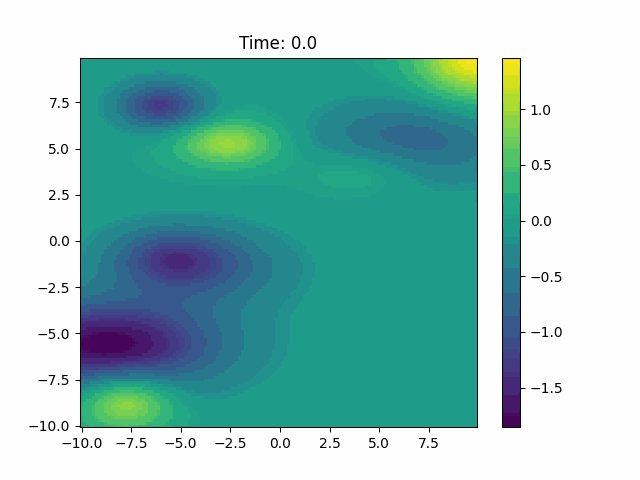

In [43]:
tspan = np.linspace(0, 10, 11)

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, args=(nx, ny, N, K, nu), method='RK45', t_eval=tspan)

fig, ax = plt.subplots()
im = ax.pcolor(x, y, w, shading='auto')
cbar = fig.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=len(tspan), interval=200, blit=False)
plt.close()
HTML(ani.to_jshtml())

ani.save('10-random-vortices.gif', writer='pillow')
display(Image(filename='10-random-vortices.gif'))

![Animation](10-random-vortices.gif)